In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

In [43]:
df = pd.read_excel("pm10s_classes500m.xlsx")

X = df[['pm10_weighted', 'Transporte', 'Urbanizado']]
y = df['pm10']

In [44]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Parameter grid for SVR
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [3],
    'C': [0.1, 1, 7, 10, 15, 20, 25, 100],
    'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5]
}

# Grid search with 5-fold CV using RMSE as scoring
grid_search = GridSearchCV(
    SVR(),
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Best model from CV
best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_r2 = r2_score(y_test, y_pred)

# Output results
print("Best parameters (from CV):", grid_search.best_params_)
print("Best CV MAE:", -grid_search.best_score_)
 # flip sign for positive RMSE
print("Test set RMSE:", test_rmse)
print("Test set R² Score:", test_r2)

if test_rmse > -grid_search.best_score_ * 1.5:
    print("⚠️ Warning: Test RMSE is much higher than CV RMSE — possible overfitting.")

Best parameters (from CV): {'C': 7, 'degree': 3, 'epsilon': 0.5, 'kernel': 'linear'}
Best CV MAE: 5.353281409298953
Test set RMSE: 5.547726207882165
Test set R² Score: 0.7061108595643342


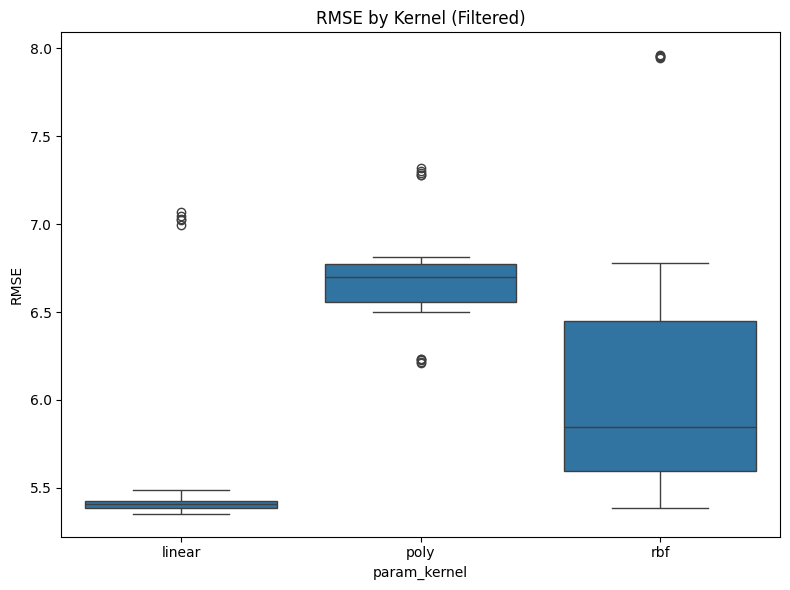

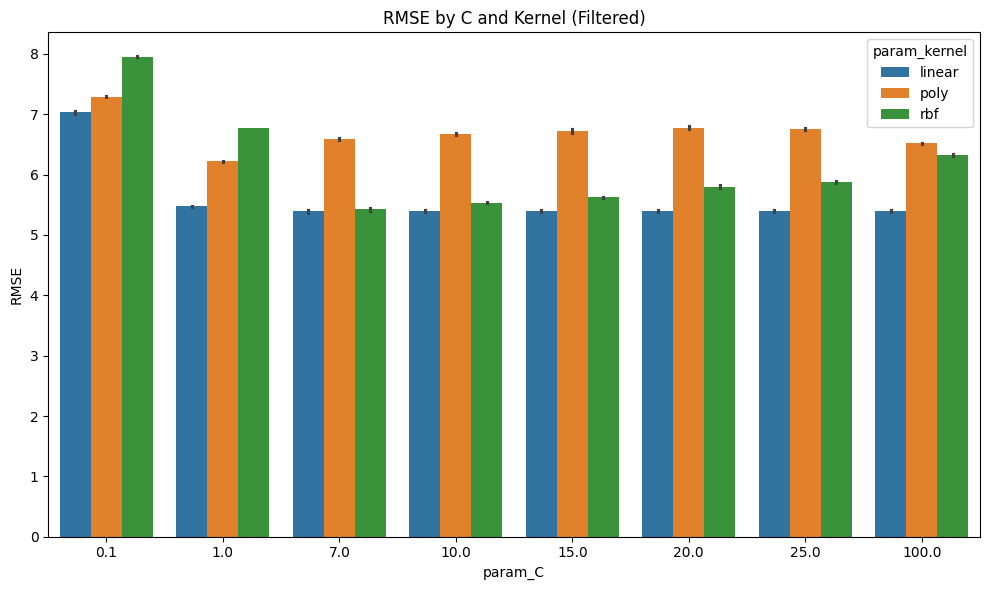

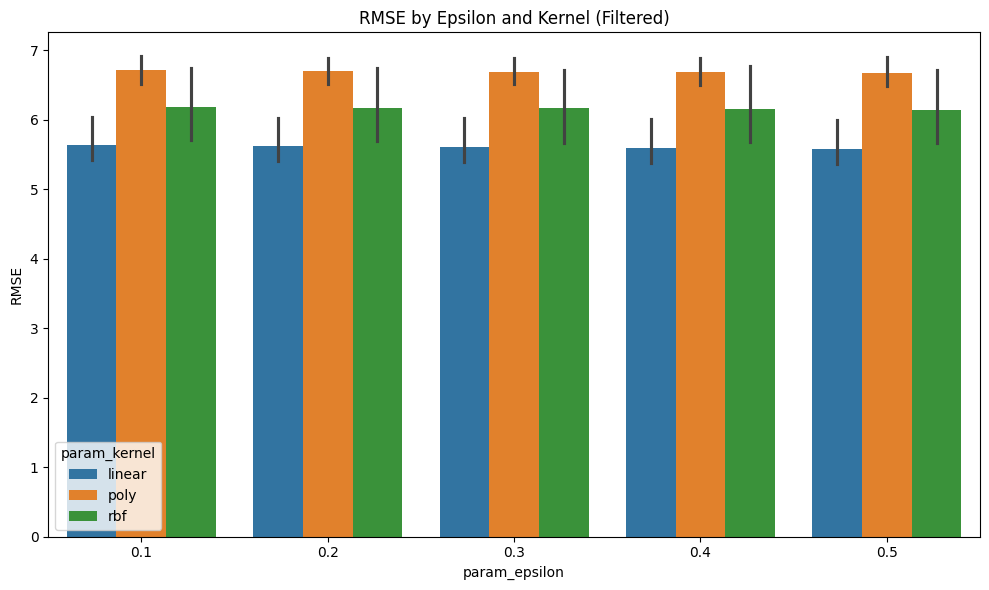

In [45]:
results_df = pd.DataFrame(grid_search.cv_results_)

# Convert to positive RMSE
results_df['RMSE'] = -results_df['mean_test_score']
# Filter out extreme RMSE values (e.g., >30)
filtered_df = results_df[results_df['RMSE'] < 30]
# Plot 1: RMSE by Kernel (filtered)
plt.figure(figsize=(8, 6))
sns.boxplot(data=filtered_df, x='param_kernel', y='RMSE')
plt.title('RMSE by Kernel (Filtered)')
plt.tight_layout()
plt.show()

# Plot 2: RMSE by C and Kernel (filtered)
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_df, x='param_C', y='RMSE', hue='param_kernel')
plt.title('RMSE by C and Kernel (Filtered)')
plt.tight_layout()
plt.show()

# Plot 3: RMSE by Epsilon and Kernel (filtered)
plt.figure(figsize=(10, 6))
sns.barplot(data=filtered_df, x='param_epsilon', y='RMSE', hue='param_kernel')
plt.title('RMSE by Epsilon and Kernel (Filtered)')
plt.tight_layout()
plt.show()


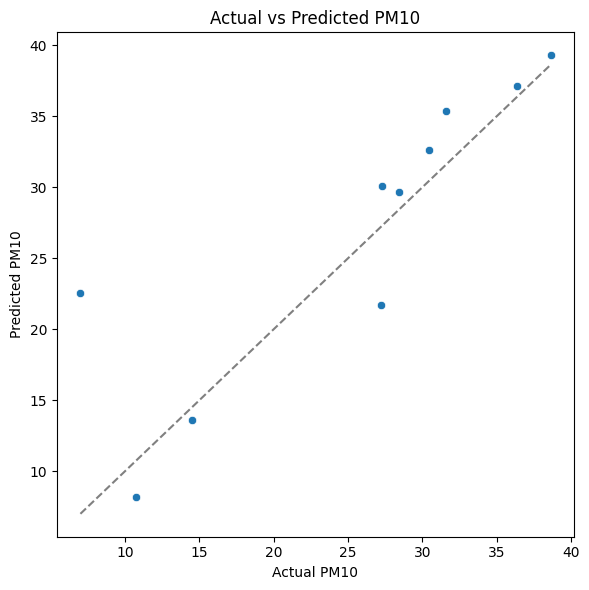

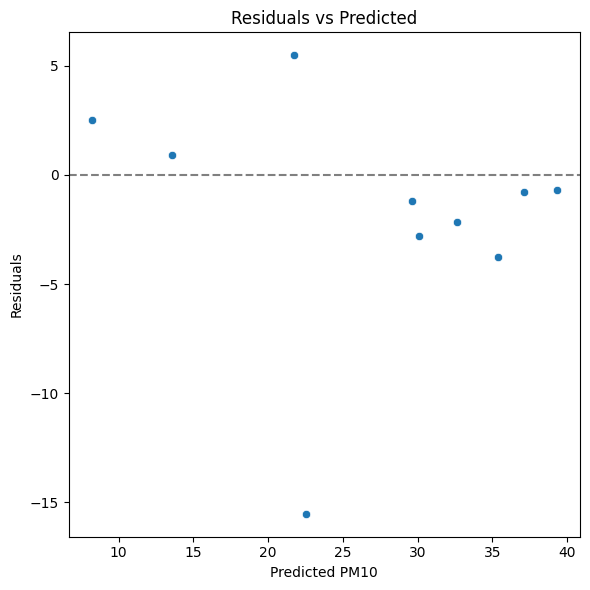

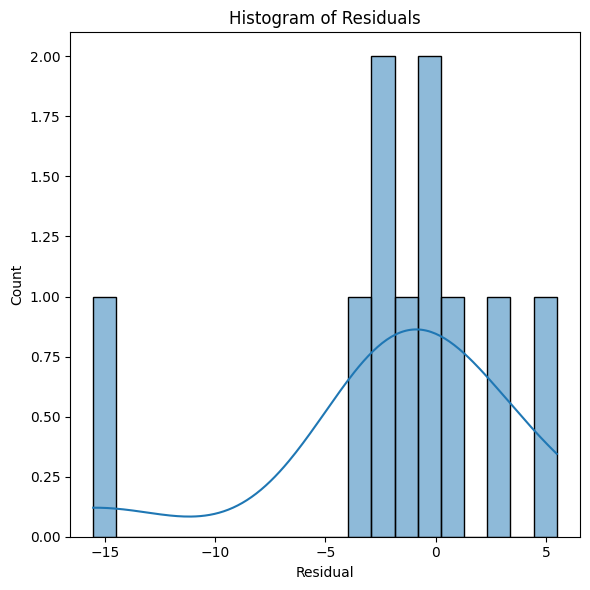

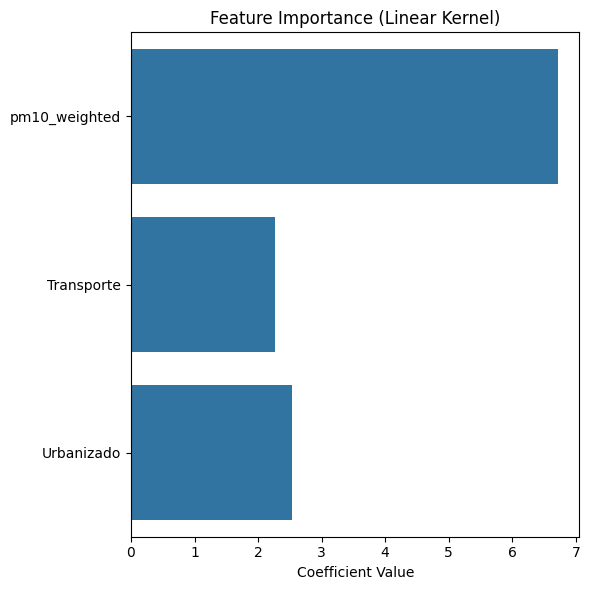

In [46]:
y_pred = best_model.predict(X_test)

# Residuals
residuals = y_test - y_pred

# Plot 1: Actual vs Predicted
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray')
plt.xlabel("Actual PM10")
plt.ylabel("Predicted PM10")
plt.title("Actual vs Predicted PM10")
plt.tight_layout()
plt.show()

# Plot 2: Residuals vs Predicted
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted PM10")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()

# Plot 3: Histogram of Residuals
plt.figure(figsize=(6, 6))
sns.histplot(residuals, kde=True, bins=20)
plt.xlabel("Residual")
plt.title("Histogram of Residuals")
plt.tight_layout()
plt.show()

# Plot 4: Feature Importance (only for linear kernel)
if best_model.kernel == 'linear':
    feature_importance = best_model.coef_.flatten()
    if isinstance(X, pd.DataFrame):
        feature_names = list(X.columns)
    else:
        feature_names = [f'x{i}' for i in range(len(feature_importance))]
    plt.figure(figsize=(6, 6))
    sns.barplot(x=feature_importance, y=feature_names)
    plt.title("Feature Importance (Linear Kernel)")
    plt.xlabel("Coefficient Value")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Feature importance is only available for linear kernel models.")

In [52]:
import joblib

# Save the trained SVR model
joblib.dump(best_model, 'svr_model.pkl')

# Save the scaler (so future input data can be standardized the same way)
joblib.dump(scaler, 'scaler.pkl')

print("Model and scaler saved.")

means = scaler.mean_
scales = scaler.scale_

original_coefs = best_model.coef_.flatten() / scales

# Corrected intercept
original_intercept = (
    best_model.intercept_[0] - np.sum((original_coefs * means))
)

# Feature names (must match training input order)
feature_names = list(X.columns)

terms = [f"{coef:.3f}*{name}" for coef, name in zip(original_coefs, X.columns)]
equation = " + ".join(terms) + f" + {original_intercept:.3f}"

print("Learned SVR model (in original units):")
print(f"pm10 = {equation}")
print(original_coefs, original_intercept)
print(original_coefs)


Model and scaler saved.
Learned SVR model (in original units):
pm10 = 1.127*pm10_weighted + 6.847*Transporte + 5.105*Urbanizado + -2.961
[1.12706469 6.84655431 5.10488119] -2.961425779285914
[1.12706469 6.84655431 5.10488119]


In [55]:
y_pred = original_intercept + X @ original_coefs
residuals = y - y_pred
print(y_pred)

0     20.307987
1     39.266308
2     23.398428
3     40.955243
4     21.711426
5     18.154912
6     33.930724
7     15.970311
8     23.029155
9     31.179290
10    19.564557
11    35.664551
12     8.209924
13    39.696091
14    27.707598
15    25.415670
16    42.007157
17    18.394995
18    28.631894
19    13.576457
20    29.844165
21    14.057937
22    13.537424
23    17.953874
24    29.648623
25    30.102603
26    32.601916
27    39.305411
28    40.040562
29    28.570224
30    25.732918
31    35.832486
32    22.582026
33    32.077783
34    20.984030
35    25.502874
36    34.419639
37    37.119382
38    23.131534
39    39.979771
40    22.530777
41    39.358552
42    30.458905
43    35.376589
44    28.413993
45    25.120324
46    22.482560
47    27.281146
dtype: float64


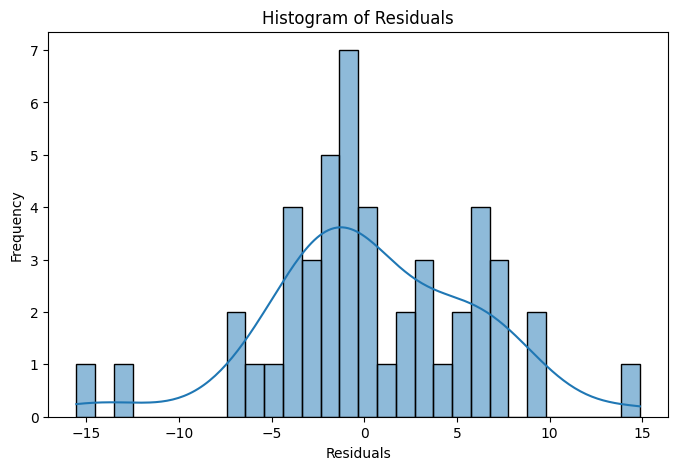

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Histogram of Residuals (Linear SVM)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


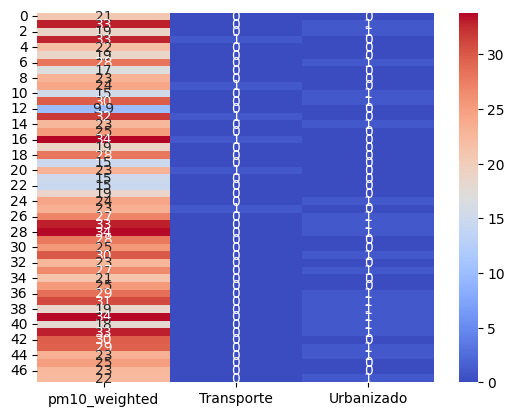

In [58]:
corr = X
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()